# Using Machine Learning to Guide Next Experiments; Active learning

In this tutorial we will take on a materials design challenge. Given 

1. a (training) dataset of materials and their properties, 
2. a candidate pool dataset with just the materials (no knowledge on their properties),

our goal will be to find the most promising candidate from the candidate pool with the best prorperties. Further, the process will be iterative. As the ML proposes a promising candidate, the experimnet will be performed on that candidate (virtually), and the associated properry will be revealed and added to the training dataset. We will achieve the following:
1. Train GPR model on train dataset
2. Use ML model prediction and uncertainties to find the best promising candidate
3. Obtain the property value of the proposed candidate and add it to the train dataset
4. Repeat steps 1-3 for 50 steps with different acquisition functions (Active learning loop)
5. Evaluate which acquisition function performs the best

Note: This tutorial is based on the data from the following publication

Quantifying machine learning model performance in materials discovery, Borg et al., arXiv.2210.13587 [cond-mat.mtrl-sci] (2022). DOI: 10.48550/arXiv.2210.13587.

In [61]:
import pandas as pd

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [63]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [64]:
from scipy.stats import norm

In [65]:
import seaborn as sns

### 0. Read train and candidate pool data

In [66]:
!gdown 1isS5qwhkRlgIPWvfwCGjISzKyCOQhamj

Downloading...
From: https://drive.google.com/uc?id=1isS5qwhkRlgIPWvfwCGjISzKyCOQhamj
To: /content/active-learning-eg-train.csv
100% 481k/481k [00:00<00:00, 111MB/s]


In [67]:
train_data = pd.read_csv('active-learning-eg-train.csv')
train_data_ori = train_data.copy()

In [68]:
nfrac = 0.05
train_data = train_data.sample(frac=nfrac)

In [69]:
train_data

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,formula,gap expt
136,34.0,68.0,34.0,45.333333,15.111111,34.0,35.0,89.0,54.0,71.000000,...,0.000000,0.0,14.0,194.0,180.0,74.000000,80.000000,14.0,ErSe2,1.07
78,30.0,52.0,22.0,41.000000,10.010000,31.0,69.0,90.0,21.0,79.500000,...,0.000000,0.0,64.0,194.0,130.0,115.580000,51.064200,64.0,Zn0.01Ga0.99Sb0.99Te0.01,0.72
32,29.0,56.0,27.0,37.090909,6.876033,34.0,9.0,89.0,80.0,69.909091,...,0.000000,0.0,14.0,229.0,215.0,74.045455,70.070248,14.0,Ba4Ga5CuSe12,1.45
327,14.0,32.0,18.0,30.839000,2.172231,32.0,78.0,79.0,1.0,78.935500,...,0.000000,0.0,225.0,227.0,2.0,225.129000,0.241359,225.0,Si0.0645Ge0.9355,1.04
65,14.0,75.0,61.0,34.333333,27.111111,14.0,54.0,78.0,24.0,70.000000,...,0.000000,0.0,194.0,227.0,33.0,216.000000,14.666667,227.0,ReSi2,0.12
371,8.0,82.0,74.0,19.535714,14.831633,8.0,46.0,89.0,43.0,82.535714,...,0.000000,0.0,12.0,229.0,217.0,50.821429,63.063776,12.0,V3Pb2Se5O18,3.14
269,16.0,80.0,64.0,46.000000,26.666667,16.0,5.0,88.0,83.0,63.888889,...,0.000000,0.0,70.0,229.0,159.0,137.333333,59.851852,70.0,Cs2Hg3S4,2.80
454,5.0,11.0,6.0,5.375000,0.703125,5.0,2.0,72.0,70.0,67.625000,...,0.000000,0.0,166.0,229.0,63.0,169.937500,7.382812,166.0,NaB15,0.32
396,15.0,49.0,34.0,32.000000,12.200000,15.0,74.0,84.0,10.0,79.000000,...,0.000000,0.0,2.0,166.0,164.0,83.850000,63.250000,2.0,In0.7Ga0.3As0.3P0.7,1.58
347,30.0,52.0,22.0,41.000000,10.100000,31.0,69.0,90.0,21.0,79.500000,...,0.000000,0.0,64.0,194.0,130.0,120.800000,51.120000,64.0,Zn0.1Ga0.9Sb0.9Te0.1,1.00


In [70]:
!gdown 1xlFg0Y9qOs5_E5mlsXuHRbhl8HGVlRhV

Downloading...
From: https://drive.google.com/uc?id=1xlFg0Y9qOs5_E5mlsXuHRbhl8HGVlRhV
To: /content/active-learning-eg-candidate.csv
100% 1.60M/1.60M [00:00<00:00, 141MB/s]


In [71]:
candidate_data = pd.read_csv('active-learning-eg-candidate.csv')
candidate_data = candidate_data.sample(frac=1, random_state=1)
candidate_data_ori = candidate_data.copy()

candidate_data

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,formula,gap expt
1198,8.0,83.0,75.0,34.400000,28.080000,8.0,9.0,94.0,85.0,72.600000,...,0.000000,0.0,12.0,229.0,217.0,65.800000,65.280000,12.0,BaBiClO2,3.71
1617,8.0,71.0,63.0,33.200000,30.240000,8.0,41.0,87.0,46.0,68.600000,...,0.001079,0.0,12.0,194.0,182.0,84.800000,87.360000,12.0,Lu2O3,5.50
1596,8.0,63.0,55.0,30.000000,26.400000,8.0,25.0,87.0,62.0,62.200000,...,0.000000,0.0,12.0,229.0,217.0,98.800000,104.160000,12.0,Eu2O3,4.50
1476,8.0,83.0,75.0,25.428571,24.326531,8.0,86.0,96.0,10.0,89.857143,...,0.000000,0.0,12.0,64.0,52.0,20.285714,12.489796,12.0,BiIO3F2,3.97
1123,29.0,65.0,36.0,44.000000,12.857143,29.0,29.0,90.0,61.0,70.142857,...,0.000000,0.0,152.0,225.0,73.0,189.285714,31.959184,152.0,Tb(CuTe)3,0.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,31.0,63.0,32.0,37.285714,7.346939,34.0,25.0,89.0,64.0,75.571429,...,0.000000,0.0,14.0,229.0,215.0,59.000000,51.428571,14.0,Eu(GaSe2)2,2.16
905,8.0,65.0,57.0,30.800000,27.360000,8.0,29.0,87.0,58.0,63.800000,...,0.000000,0.0,12.0,194.0,182.0,84.800000,87.360000,12.0,Tb2O3,3.00
1096,8.0,59.0,51.0,42.960000,12.832000,34.0,17.0,89.0,72.0,60.120000,...,0.000000,0.0,12.0,194.0,182.0,85.920000,86.464000,14.0,Pr10Se14O,1.89
235,35.0,83.0,48.0,47.000000,18.000000,35.0,86.0,95.0,9.0,92.750000,...,0.000000,0.0,12.0,64.0,52.0,51.000000,19.500000,64.0,BiBr3,2.66


### Comments about the datasets
Two datasets have been provided:
1. train dataset (N=500): materials for which features and target property are already known
2. candidate dataset (N=1655): materials which we believe might have better target property but measuremnets are not yet made. Features for these materials have been provided to make ML predictions

In [72]:
Xcols = train_data.columns[train_data.columns.str.contains("MagpieData ")]
Xcols

Index(['MagpieData minimum Number', 'MagpieData maximum Number',
       'MagpieData range Number', 'MagpieData mean Number',
       'MagpieData avg_dev Number', 'MagpieData mode Number',
       'MagpieData minimum MendeleevNumber',
       'MagpieData maximum MendeleevNumber',
       'MagpieData range MendeleevNumber', 'MagpieData mean MendeleevNumber',
       ...
       'MagpieData range GSmagmom', 'MagpieData mean GSmagmom',
       'MagpieData avg_dev GSmagmom', 'MagpieData mode GSmagmom',
       'MagpieData minimum SpaceGroupNumber',
       'MagpieData maximum SpaceGroupNumber',
       'MagpieData range SpaceGroupNumber', 'MagpieData mean SpaceGroupNumber',
       'MagpieData avg_dev SpaceGroupNumber',
       'MagpieData mode SpaceGroupNumber'],
      dtype='object', length=132)

In [73]:
X = train_data[Xcols]
X

candidate_X = candidate_data[Xcols]

In [74]:
target_col = 'gap expt'
y = train_data[target_col]
y

136    1.07
78     0.72
32     1.45
327    1.04
65     0.12
371    3.14
269    2.80
454    0.32
396    1.58
347    1.00
335    1.50
168    1.37
433    1.80
247    2.03
40     0.40
56     0.30
126    0.67
98     1.18
246    1.60
166    2.20
275    0.17
121    2.30
111    0.46
494    3.10
174    1.00
Name: gap expt, dtype: float64

In [75]:
best_train = np.max(y)
print("Current best candidate property is: ", best_train)
print("Our objective is to efficiently find materials from the candidate pool that have high target property.")

Current best candidate property is:  3.14
Our objective is to efficiently find materials from the candidate pool that have high target property.


### 1. Train GPR model

In [76]:
# Function definitions

def train_gpr_model(X, y, hyperparams = None, cv = False, return_cv = False):
    """
    Function to train the GPR model on the given data X (features) and y (target property). 
    If hyperparams argument is passed, all possible combinations of alpha and kernel values
    will be tried to find combination with minimum CV error. The final GPR model is trained
    using the fixed kernel and alpha params as determined using CV.
    """
    
    if cv:
        cv_results = {'kernel':[],'alpha':[],'cv_rmse':[]}
        for k, a in itertools.product(hyperparams['kernel'], hyperparams['alpha']):

            gaussian_process = GaussianProcessRegressor(
            kernel=k, alpha=a, n_restarts_optimizer=3
            )

            cv_error, k_opt = run_cv(gaussian_process, X, y, n_cv = 5, normalize=True)
            cv_results['cv_rmse'].append(cv_error)
            cv_results['kernel'].append(k_opt)
            cv_results['alpha'].append(a)

        cv_results = pd.DataFrame(cv_results)
        cv_results = cv_results.sort_values('cv_rmse')
        k_opt = cv_results.iloc[0]['kernel']
        alpha_opt = cv_results.iloc[0]['alpha']

        print()
        print('Best kernel with lowest CV error')
        print('sigma_c %.4f' %np.sqrt(k_opt.k1.constant_value), 'sigma_l %.4f' %k_opt.k2.length_scale, 'alpha', alpha_opt)
        
    else:
        k_opt = hyperparams['kernel'][0]
        alpha_opt = hyperparams['alpha'][0]

    #gaussian_process = GaussianProcessRegressor(kernel=k_opt, alpha=alpha_opt, n_restarts_optimizer=1)
    gaussian_process = get_gpr_pipeline(k_opt, alpha_opt)
    model = gaussian_process.fit(X,y)
    
    return [model, cv_results] if return_cv else model


def run_cv(ml_model, X, y, n_cv = 5, normalize=False):
    """
    Function to run Cross-validation
    """
    kf = KFold(n_splits=n_cv)
    scaler = StandardScaler()
    errors = []
    models = []

    for idx, (train, val) in enumerate(kf.split(X)):
        
        if normalize:
            _X_cv_train = X.values[train]
            _X_cv_val = X.values[val]

            X_cv_train = scaler.fit_transform(_X_cv_train)
            X_cv_val = scaler.transform(_X_cv_val)
            
        else:
            X_cv_train = X.values[train]
            X_cv_val = X.values[val]

        y_cv_train = y.values[train]
        y_cv_val = y.values[val]    

        # Model fit and prediction
        model = ml_model.fit(X_cv_train, y_cv_train)
        y_pred_val = model.predict(X_cv_val)

        # Computing errors
        rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))

        errors.append(rmse_val)
        models.append(model)
        
    errors = np.array(errors)
    k_opt = models[np.argmin(errors)].kernel_
    
    return np.mean(errors), k_opt

In [77]:
def get_gpr_pipeline(k_opt, alpha_opt):
    steps = [
        ('scaler', StandardScaler()),  # normalize the data
        ('regressor', GaussianProcessRegressor(kernel=k_opt, alpha=alpha_opt, optimizer=None))
    ]

    # create the pipeline
    gpr_pipeline = Pipeline(steps=steps)
    return gpr_pipeline

In [78]:
def expected_improvement(X_candidate, X_train, ml_model, trade_off=0.01):
    y_pred, y_std = ml_model.predict(X_candidate, return_std=True)
    y_train, y_train_std = ml_model.predict(X_train, return_std=True)

    # Needed for noise-based model,
    # otherwise use np.max(Y_train)
    mu_train_opt = np.max(y_train)

    with np.errstate(divide='warn'):
        imp = y_pred - mu_train_opt - trade_off
        Z = imp / y_std
        ei = imp * norm.cdf(Z) + y_std * norm.pdf(Z)
        ei[y_std == 0.0] = 0.0
    return ei

In [79]:
hyperparams={'kernel': [1 * RBF(length_scale=1)],
             'alpha':[0.01, 0.1, 0.2, 0.3]}

In [80]:
ml_model, cv_results = train_gpr_model(X,y,hyperparams=hyperparams, cv=True, return_cv=True)


Best kernel with lowest CV error
sigma_c 1.5054 sigma_l 26.6982 alpha 0.2


In [81]:
cv_results

,kernel,alpha,cv_rmse
2,1.51**2 * RBF(length_scale=26.7),0.20,0.742525
3,1.47**2 * RBF(length_scale=30.7),0.30,0.760385
1,1.39**2 * RBF(length_scale=15.4),0.10,0.768318
0,1.41**2 * RBF(length_scale=9.47),0.01,0.894380


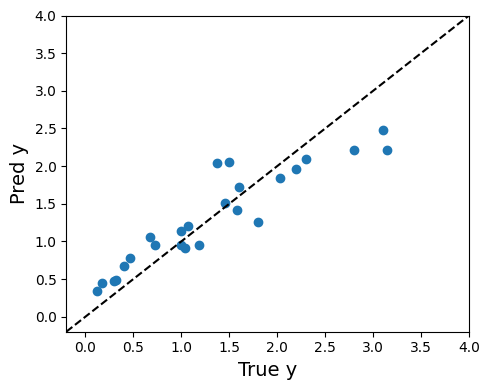

In [82]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
ax1.scatter(y, ml_model.predict(X))
ax1.plot([-0.2,4], [-0.2,4], '--k')

ax1.set_xlabel("True y", fontsize=14)
ax1.set_ylabel("Pred y", fontsize=14)

ax1.set_xlim([-0.2,4])
ax1.set_ylim([-0.2,4])

plt.tight_layout()

### 2.1 Compute Expected improvement for Candidate pool

In [83]:
trade_off = 0.01
y_pred, y_std = ml_model.predict(candidate_X, return_std=True)
y_train, y_train_std = ml_model.predict(X, return_std=True)

# Needed for noise-based model,
# otherwise use np.max(Y_train)
mu_train_opt = np.max(y_train)

with np.errstate(divide='warn'):
    imp = y_pred - mu_train_opt - trade_off
    Z = imp / y_std
    ei = imp * norm.cdf(Z) + y_std * norm.pdf(Z)
    ei[y_std == 0.0] = 0.0

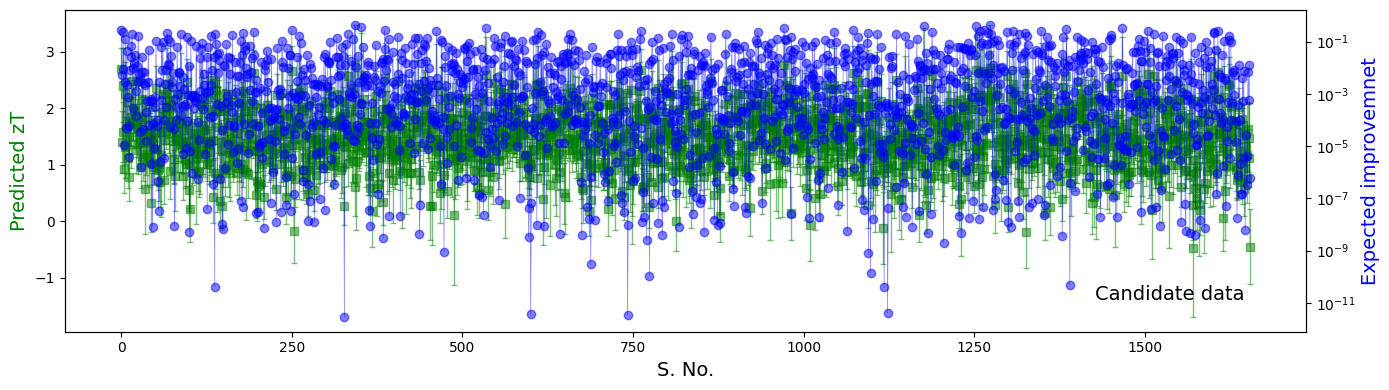

In [84]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(14,4))

ax1.errorbar(np.arange(len(y_pred)), y_pred, y_std, fmt='-s', c='g', alpha=0.5, elinewidth=1, capsize=2, lw=0.5)
#ax1.plot([50,900], [50,900], '--k')

ax1.set_xlabel('S. No.', fontsize=14)
ax1.set_ylabel('Predicted zT', fontsize=14, color='g')

ax1.text(0.95, 0.1, "Candidate data", transform=ax1.transAxes, ha='right', fontsize=14)
#ax1.text(0.95, 0.18, "RMSE: %.2f"%rmse_train, transform=ax1.transAxes, ha='right', fontsize=14)
#ax1.text(0.95, 0.1, "R2: %.2f"%r2_train, transform=ax1.transAxes, ha='right', fontsize=14)    

#ax1.set_xlim([50,900])
#ax1.set_ylim([-0.2,0.5])

ax2 = ax1.twinx()

ax2.plot(ei, '-bo', lw=0.5, alpha=0.5)
ax2.set_yscale('log')
ax2.set_ylabel('Expected improvemnet', fontsize=14, color='b')

plt.tight_layout()
plt.show()



### Better visualization: Plot for first 50 candidates 

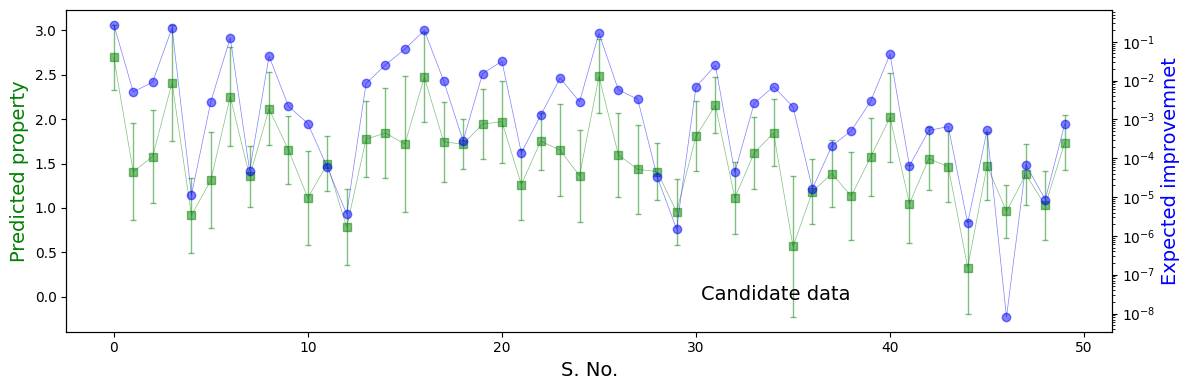

In [85]:
nplots = 50
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12,4))

ax1.errorbar(np.arange(len(y_pred))[:nplots], y_pred[:nplots], y_std[:nplots], fmt='-s', c='g', alpha=0.5, elinewidth=1, capsize=2, lw=0.5)
#ax1.plot([50,900], [50,900], '--k')

ax1.set_xlabel('S. No.', fontsize=14)
ax1.set_ylabel('Predicted property', fontsize=14, color='g')

ax1.text(0.75, 0.1, "Candidate data", transform=ax1.transAxes, ha='right', fontsize=14)
#ax1.text(0.95, 0.18, "RMSE: %.2f"%rmse_train, transform=ax1.transAxes, ha='right', fontsize=14)
#ax1.text(0.95, 0.1, "R2: %.2f"%r2_train, transform=ax1.transAxes, ha='right', fontsize=14)    

#ax1.set_xlim([50,900])
#ax1.set_ylim([-0.2,0.5])

ax2 = ax1.twinx()

ax2.plot(ei[:nplots], '-bo', lw=0.5, alpha=0.5)
ax2.set_yscale('log')
ax2.set_ylabel('Expected improvemnet', fontsize=14, color='b')

plt.tight_layout()
plt.show()



### Question
1. Do you notice any trend in the EI value? When is it small and when is it large?

### 2.2 Selecting candidate with maximum EI

In [86]:
print("Best target property sample so far in the train data is %.4f" %best_train)

Best target property sample so far in the train data is 3.1400


In [87]:
sel_idx = np.argmax(ei)

print("Selected candidate for next experiment ", candidate_data.iloc[sel_idx]['formula'])

Selected candidate for next experiment  RbH2(IO3)3


### 2.3 Next we do the experimnet and find the actual value

In [88]:
# Assume the experimnet was performed the zT value was measured
print("Exp. value for the selected candidate %.4f" %candidate_data.iloc[sel_idx][target_col])

Exp. value for the selected candidate 4.0700


### 2.4 Next we update the training data and candidate pool 

In [89]:
# Add selected data to training data
train_data = pd.concat([train_data, candidate_data.iloc[sel_idx].to_frame().T], ignore_index=True)

# Delete selected data from candidate pool
candidate_data = candidate_data.drop(index=candidate_data.iloc[sel_idx].name)

In [90]:
print("New train data size:", len(train_data), "\nNew candidate data size: ", len(candidate_data))

New train data size: 26 
New candidate data size:  1654


### 3.1 Complete Active learning loop (with Expected Impeovemnet)
Next we perform all steps in active learning in a loop for 50 steps and accumulate the results

In [91]:
results_ei = []

In [92]:
hyperparams={'kernel': [cv_results.iloc[0]['kernel']],
            'alpha':[cv_results.iloc[0]['alpha']]}

In [93]:
train_data = train_data_ori.copy()
candidate_data = candidate_data_ori.copy()

In [94]:
nloop = 50

In [95]:
trade_off = 0.01
for exp_idx in range(nloop):
    
    # Step 1: Train ML model
    ml_model = train_gpr_model(X,y,hyperparams=hyperparams)
    
    # Step 2: Evaluate Acquisition function
    ei = expected_improvement(candidate_X, X, ml_model, trade_off)
        
    # Step 3: Select best candidate
    sel_idx = np.argmax(ei)
    print("Selected candidate", candidate_data.iloc[sel_idx]['formula'])
    
    # Step 4: Perform experimnet and update training and candidate data pool
    results_ei.append(candidate_data.iloc[sel_idx][target_col])
    print("Exp. value for the selected candidate %.4f" %candidate_data.iloc[sel_idx][target_col])
    train_data = pd.concat([train_data, candidate_data.iloc[sel_idx].to_frame().T], ignore_index=True)
    candidate_data = candidate_data.drop(index=candidate_data.iloc[sel_idx].name)    
    print("Training data size: ", len(train_data), "\n Candidate pool size: ", len(candidate_data))

    X = train_data[Xcols]
    candidate_X = candidate_data[Xcols]
    y = train_data[target_col]

Selected candidate RbH2(IO3)3
Exp. value for the selected candidate 4.0700
Training data size:  501 
 Candidate pool size:  1654
Selected candidate BaBClF4
Exp. value for the selected candidate 6.8900
Training data size:  502 
 Candidate pool size:  1653
Selected candidate MgF2
Exp. value for the selected candidate 11.1000
Training data size:  503 
 Candidate pool size:  1652
Selected candidate CaF2
Exp. value for the selected candidate 9.9200
Training data size:  504 
 Candidate pool size:  1651
Selected candidate PH6NO4
Exp. value for the selected candidate 6.8000
Training data size:  505 
 Candidate pool size:  1650
Selected candidate H7Se2NO6
Exp. value for the selected candidate 4.8100
Training data size:  506 
 Candidate pool size:  1649
Selected candidate LiEuH3
Exp. value for the selected candidate 1.5000
Training data size:  507 
 Candidate pool size:  1648
Selected candidate Mg5B3O9F
Exp. value for the selected candidate 5.6300
Training data size:  508 
 Candidate pool size: 

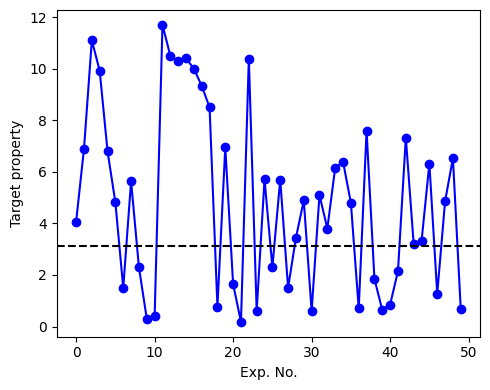

In [96]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
ax1.plot(results_ei, '-bo', label='EI')
ax1.axhline(y=best_train, linestyle = '--', c='k')
ax1.set_xlabel('Exp. No.')
ax1.set_ylabel('Target property')

plt.tight_layout()

In [97]:
max(results_ei)

11.7

In [98]:
(results_ei > best_train).sum()

32

In [99]:
np.argmax(results_ei)

11

### 3.2 Active learning loop (with only Exploitation)

In [100]:
results_exploit = []
train_data = train_data_ori.copy()
candidate_data = candidate_data_ori.copy()

In [101]:
for exp_idx in range(nloop):
    
    # Step 1: Train ML model
    ml_model = train_gpr_model(X,y,hyperparams=hyperparams)
    
    # Step 2: Evaluate Acquisition function
    y_pred, y_std = ml_model.predict(candidate_X, return_std=True)
        
    # Step 3: Select best candidate
    sel_idx = np.argmax(y_pred)
    print("Selected candidate", candidate_data.iloc[sel_idx]['formula'])
    
    # Step 4: Perform experimnet and update training and candidate data pool
    results_exploit.append(candidate_data.iloc[sel_idx][target_col])
    print("Exp. value for the selected candidate %.4f" %candidate_data.iloc[sel_idx][target_col])
    train_data = pd.concat([train_data, candidate_data.iloc[sel_idx].to_frame().T], ignore_index=True)
    candidate_data = candidate_data.drop(index=candidate_data.iloc[sel_idx].name)    
    print("Training data size: ", len(train_data), "\n Candidate pool size: ", len(candidate_data))

    X = train_data[Xcols]
    candidate_X = candidate_data[Xcols]
    y = train_data[target_col]

Selected candidate Sm3Al0.33Si1S7
Exp. value for the selected candidate 2.2600
Training data size:  501 
 Candidate pool size:  1654
Selected candidate BaBClF4
Exp. value for the selected candidate 6.8900
Training data size:  502 
 Candidate pool size:  1653
Selected candidate CaF2
Exp. value for the selected candidate 9.9200
Training data size:  503 
 Candidate pool size:  1652
Selected candidate MgF2
Exp. value for the selected candidate 11.1000
Training data size:  504 
 Candidate pool size:  1651
Selected candidate Mg5B3O9F
Exp. value for the selected candidate 5.6300
Training data size:  505 
 Candidate pool size:  1650
Selected candidate MnF2
Exp. value for the selected candidate 9.9000
Training data size:  506 
 Candidate pool size:  1649
Selected candidate KTi2F7
Exp. value for the selected candidate 6.4000
Training data size:  507 
 Candidate pool size:  1648
Selected candidate CdF2
Exp. value for the selected candidate 6.0000
Training data size:  508 
 Candidate pool size:  1

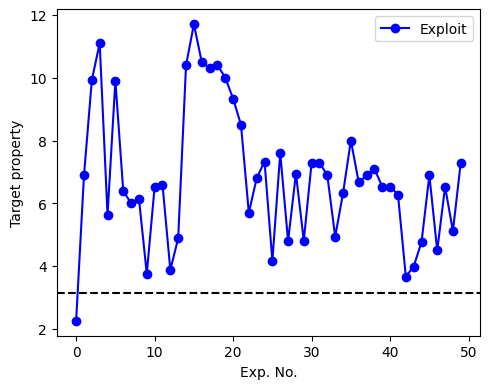

In [102]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
ax1.plot(results_exploit, '-bo', label='Exploit')
ax1.axhline(y=best_train, linestyle = '--', c='k')
ax1.set_xlabel('Exp. No.')
ax1.set_ylabel('Target property')
ax1.legend()

plt.tight_layout()

In [103]:
(results_exploit > best_train).sum()

49

In [104]:
max(results_exploit)

11.7

In [105]:
np.argmax(results_exploit)

15

### 3.3 Active learning loop (with only Exploration)

In [106]:
results_explore = []
train_data = train_data_ori.copy()
candidate_data = candidate_data_ori.copy()

In [107]:
for exp_idx in range(nloop):
    
    # Step 1: Train ML model
    ml_model = train_gpr_model(X,y,hyperparams=hyperparams)
    
    # Step 2: Evaluate Acquisition function
    y_pred, y_std = ml_model.predict(candidate_X, return_std=True)
        
    # Step 3: Select best candidate
    sel_idx = np.argmax(y_std)
    print("Selected candidate", candidate_data.iloc[sel_idx]['formula'])
    
    # Step 4: Perform experimnet and update training and candidate data pool
    results_explore.append(candidate_data.iloc[sel_idx][target_col])
    print("Exp. value for the selected candidate %.4f" %candidate_data.iloc[sel_idx][target_col])
    train_data = pd.concat([train_data, candidate_data.iloc[sel_idx].to_frame().T], ignore_index=True)
    candidate_data = candidate_data.drop(index=candidate_data.iloc[sel_idx].name)    
    print("Training data size: ", len(train_data), "\n Candidate pool size: ", len(candidate_data))

    X = train_data[Xcols]
    candidate_X = candidate_data[Xcols]
    y = train_data[target_col]

Selected candidate Zn0.4Hg0.6Se1
Exp. value for the selected candidate 0.4200
Training data size:  501 
 Candidate pool size:  1654
Selected candidate Sm2Sc3
Exp. value for the selected candidate 2.3000
Training data size:  502 
 Candidate pool size:  1653
Selected candidate TiFe2Si
Exp. value for the selected candidate 0.4000
Training data size:  503 
 Candidate pool size:  1652
Selected candidate EuH2
Exp. value for the selected candidate 1.8500
Training data size:  504 
 Candidate pool size:  1651
Selected candidate Sc2Fe
Exp. value for the selected candidate 0.7700
Training data size:  505 
 Candidate pool size:  1650
Selected candidate Zr6O
Exp. value for the selected candidate 0.1800
Training data size:  506 
 Candidate pool size:  1649
Selected candidate PH6NO4
Exp. value for the selected candidate 6.8000
Training data size:  507 
 Candidate pool size:  1648
Selected candidate Ti1C0.9
Exp. value for the selected candidate 0.3000
Training data size:  508 
 Candidate pool size:  1

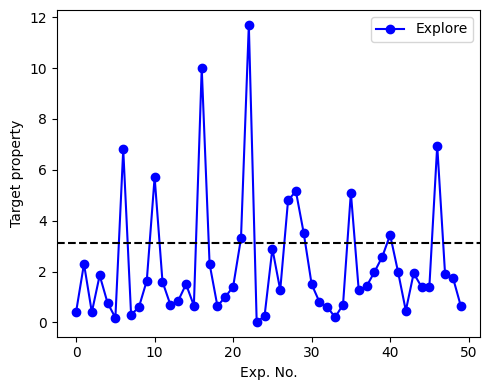

In [108]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
ax1.plot(results_explore, '-bo', label='Explore')
ax1.axhline(y=best_train, linestyle = '--', c='k')
ax1.set_xlabel('Exp. No.')
ax1.set_ylabel('Target property')
ax1.legend()

plt.tight_layout()

In [109]:
(results_explore > best_train).sum()

11

In [110]:
max(results_explore)

11.7

### 3.4 Active learning with random selection

In [111]:
results_random = []
train_data = train_data_ori.copy()
candidate_data = candidate_data_ori.copy()

In [112]:
for exp_idx in range(nloop):

    # Step 3: Select candidate
    sel_idx = np.random.choice(candidate_data.index)
    print("Selected candidate", candidate_data.loc[sel_idx]['formula'])

    # Step 4: Perform experimnet and update training and candidate data pool
    results_random.append(candidate_data.loc[sel_idx][target_col])
    print("Exp. value for the selected candidate %.4f" %candidate_data.loc[sel_idx][target_col])
    train_data = pd.concat([train_data, candidate_data.loc[sel_idx].to_frame().T], ignore_index=True)
    candidate_data = candidate_data.drop(index=candidate_data.loc[sel_idx].name)    
    print("Training data size: ", len(train_data), "\n Candidate pool size: ", len(candidate_data))

    X = train_data[Xcols]
    candidate_X = candidate_data[Xcols]
    y = train_data[target_col]

Selected candidate Ga1As0.9P0.1
Exp. value for the selected candidate 1.5000
Training data size:  501 
 Candidate pool size:  1654
Selected candidate CuBiPbSe3
Exp. value for the selected candidate 0.0700
Training data size:  502 
 Candidate pool size:  1653
Selected candidate VTeHO5
Exp. value for the selected candidate 2.5100
Training data size:  503 
 Candidate pool size:  1652
Selected candidate As2Ru
Exp. value for the selected candidate 0.8000
Training data size:  504 
 Candidate pool size:  1651
Selected candidate BiBr3
Exp. value for the selected candidate 2.6600
Training data size:  505 
 Candidate pool size:  1650
Selected candidate Cs2ZnGe3Se8
Exp. value for the selected candidate 2.3100
Training data size:  506 
 Candidate pool size:  1649
Selected candidate K2PAuS4
Exp. value for the selected candidate 2.6300
Training data size:  507 
 Candidate pool size:  1648
Selected candidate CuSbS2
Exp. value for the selected candidate 1.3800
Training data size:  508 
 Candidate pool

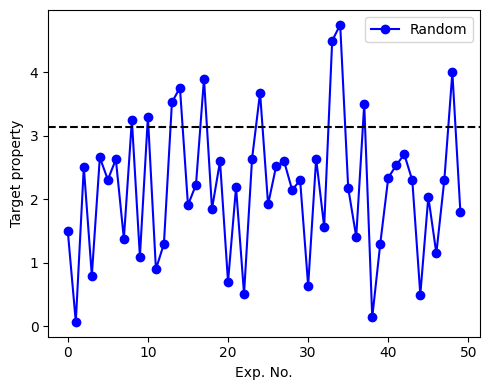

In [113]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
ax1.plot(results_random, '-bo', label='Random')
ax1.axhline(y=best_train, linestyle = '--', c='k')
ax1.set_xlabel('Exp. No.')
ax1.set_ylabel('Target property')
ax1.legend()

plt.tight_layout()

In [114]:
(results_random > best_train).sum()

10

In [115]:
np.argmax(results_random)

34

### 4.1 Comparision Plot: Results from various acquisition function

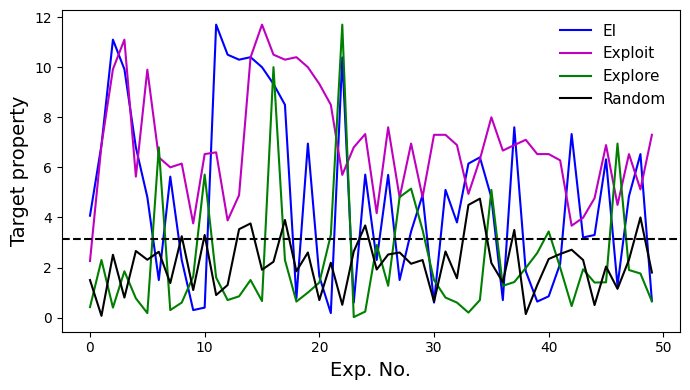

In [116]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(7,4))

ax1.plot(results_ei, c='b', label='EI')
ax1.plot(results_exploit, c='m', label='Exploit')
ax1.plot(results_explore, c='g', label='Explore')
ax1.plot(results_random, c='k', label='Random')


ax1.axhline(y=best_train, linestyle = '--', c='k')
ax1.set_xlabel('Exp. No.', fontsize=14)
ax1.set_ylabel('Target property', fontsize=14)
ax1.legend(frameon=False, fontsize=11)

plt.tight_layout()


### 4.2 Comparision Plot: Distribution of target property of new candidates

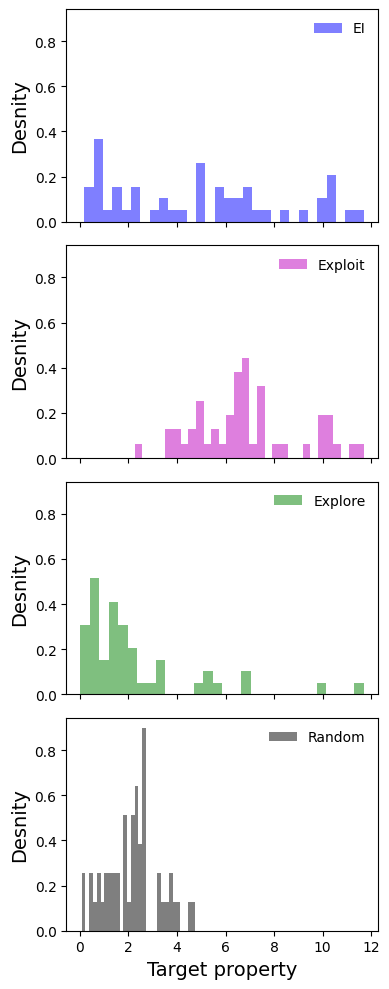

In [117]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(4,10), sharex=True, sharey=True)
axs = axs.ravel()
all_results = [results_ei, results_exploit, results_explore, results_random]
cols = ['b', 'm', 'g', 'k']
labels = ['EI','Exploit','Explore','Random']

for res, ax, c, l in zip(all_results, axs, cols, labels):
    ax.hist(res, bins=30, alpha=0.5, density=True, color=c, label=l)
    ax.legend(frameon=False)
    ax.set_ylabel('Desnity', fontsize=14)

ax.set_xlabel('Target property', fontsize=14)    
plt.tight_layout()

### Question
2. Does EI and exploitation always perform better than exploration/random search?
3. What other improvemnets can be made in terms of ML model training?
4. Try different values of the nfrac parameter and see how many trials does the different acquisition functions take ON AVERAGE to suggest the highest bandgap system (=11.7 eV)? Remember for each value of nfrac you will have to run the above code multiple times to get good statistics. Convey your results using plots.